In [1]:
%load_ext lab_black
%cd ..

/mnt/h/hev/motion-keypoint


In [2]:
import argparse
import json
import math
import shutil
import sys
from pathlib import Path

import cv2
import imageio
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

import networks
import options
import utils
from datasets import get_det_dataset

import matplotlib.pyplot as plt
import pandas as pd
from easydict import EasyDict
import yaml
import os
from importlib import import_module

In [6]:
with open("config/effdet-d4.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))

In [7]:
main = import_module("main-effdet-train")

In [8]:
trainer = main.DetTrainer(C, 1)

Load pretrained /home/s0/.cache/torch/hub/checkpoints/efficientdet-d4.pth


In [9]:
model = trainer.det_model

In [ ]:
model.load_state_dict(torch.load("results/effdet-train/ckpt-efficientdet-d8_SAM_1.pth")["model"])

In [11]:
model.eval()
torch.set_grad_enabled(False)

In [12]:
ds_train = trainer.dl_train.dataset
ds_valid = trainer.dl_valid.dataset

In [13]:
ds_train[0]

('data/ori/train_imgs/001-1-1-01-Z17_A-0000001.jpg',
 tensor([[[1.6324, 1.6495, 1.6153,  ..., 2.2489, 2.2489, 2.2489],
          [1.6838, 1.7009, 1.6838,  ..., 2.2489, 2.2489, 2.2489],
          [1.6667, 1.6838, 1.6838,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [0.8618, 0.8618, 0.8618,  ..., 2.2489, 2.2489, 2.2489],
          [0.8789, 0.8789, 0.8961,  ..., 2.2489, 2.2489, 2.2489],
          [0.8961, 0.8961, 0.9303,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.0084, 2.0259, 1.9909,  ..., 2.4286, 2.4286, 2.4286],
          [2.0609, 2.0784, 2.0609,  ..., 2.4286, 2.4286, 2.4286],
          [2.0434, 2.0609, 2.0609,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [0.9755, 0.9755, 0.9755,  ..., 2.4286, 2.4286, 2.4286],
          [1.0805, 1.0805, 1.0980,  ..., 2.4286, 2.4286, 2.4286],
          [1.0980, 1.0980, 1.1155,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.1171, 2.1346, 2.0823,  ..., 2.4483, 2.4483, 2.4483],
          [2.1694, 2.1868, 2.1694,  ..., 2.4831, 2.46

## batch_augmentation 잘 돌아가는지 확인

### rotation

In [100]:
file, img, tannot = ds_valid[0]

In [101]:
tannot

tensor([[345.0000, 163.0000, 482.0000, 450.7811,   0.0000]])

In [102]:
k = 2
a, b, c, d = tannot[..., 0], tannot[..., 1], tannot[..., 2], tannot[..., 3]
e = tannot[..., 4]

In [103]:
h, w = img.shape[1:]

In [104]:
if k == 1:
    tannot = torch.stack([b, w - c, d, w - a, e], dim=1)
elif k == 2:
    tannot = torch.stack([w - c, h - d, w - a, h - b, e], dim=1)
elif k == 3:
    tannot = torch.stack([h - d, a, h - b, c, e], dim=1)

In [105]:
tannot

tensor([[286.0000,  61.2189, 423.0000, 349.0000,   0.0000]])

In [108]:
tannot_ = tannot[0].type(torch.int).tolist()

In [106]:
img_ = torch.rot90(img, k=k, dims=(1, 2))

In [107]:
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))

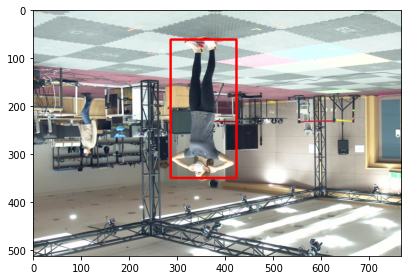

In [113]:
utils.imshows(
    cv2.rectangle(
        img_np,
        (int(tannot_[0]), int(tannot_[1])),
        (int(tannot_[2]), int(tannot_[3])),
        (255, 0, 0),
        3,
    )
)

### downsample

In [114]:
file, img, tannot = ds_valid[0]
tannot

tensor([[345.0000, 163.0000, 482.0000, 450.7811,   0.0000]])

In [115]:
h, w = img.shape[1:]

In [117]:
tannot.shape

torch.Size([1, 5])

In [116]:
img_ = F.interpolate(img, (h//2,w//2))
tannot[:4] *= 0.5

ValueError: size shape must match input shape. Input is 1D, size is 2

## Valid 데이터에서 실험

In [11]:
j = 161

data/ori/train_imgs/210-2-1-11-Z36_E-0000005.jpg
tensor([[565.5190, 317.1981, 759.2345, 907.1089,   0.0000]])


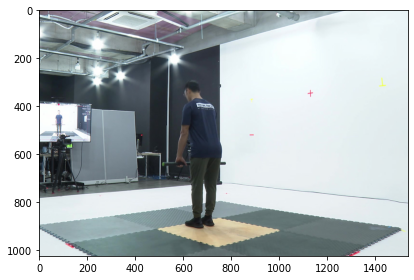

In [12]:
file, img, annot = ds_valid[j]
print(file)
print(annot)
utils.imshows(utils.denormalize(img).permute(1, 2, 0))

In [13]:
pannot = model(img.unsqueeze(0).cuda())[0]
pannot

{'rois': array([[565.29425, 339.26498, 755.4722 , 897.4756 ]], dtype=float32),
 'class_ids': array([0]),
 'scores': array([0.96768403], dtype=float32)}

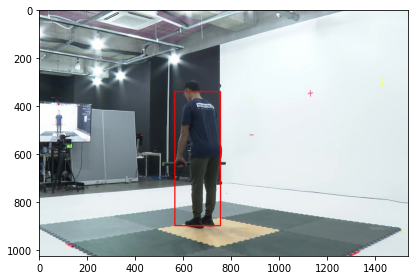

In [14]:
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

## 이미지 변형해서 테스트

### Gamma Correction (gamma = 0.9)

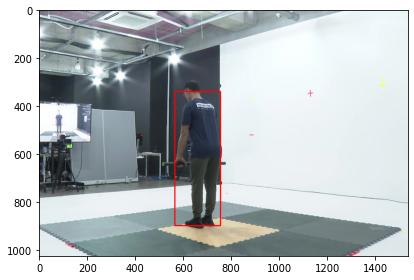

In [15]:
img_ = utils.normalize(utils.denormalize(img) ** 0.9)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

### Gamma Correction (gamma = 0.8)

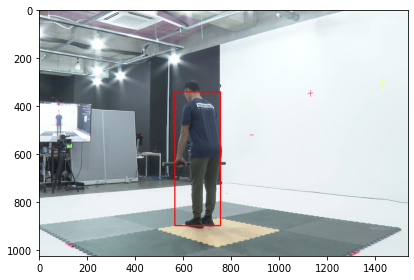

In [16]:
img_ = utils.normalize(utils.denormalize(img) ** 0.8)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

### Gamma Correction (gamma = 0.7)

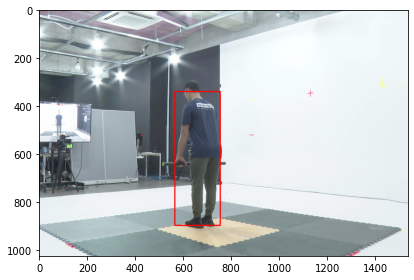

In [17]:
img_ = utils.normalize(utils.denormalize(img) ** 0.7)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

### Gamma Correction (gamma = 0.4)

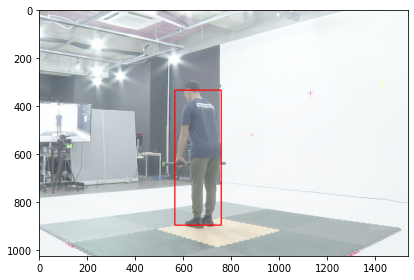

In [18]:
img_ = utils.normalize(utils.denormalize(img) ** 0.4)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

### Gamma Correction (gamma = 0.2)

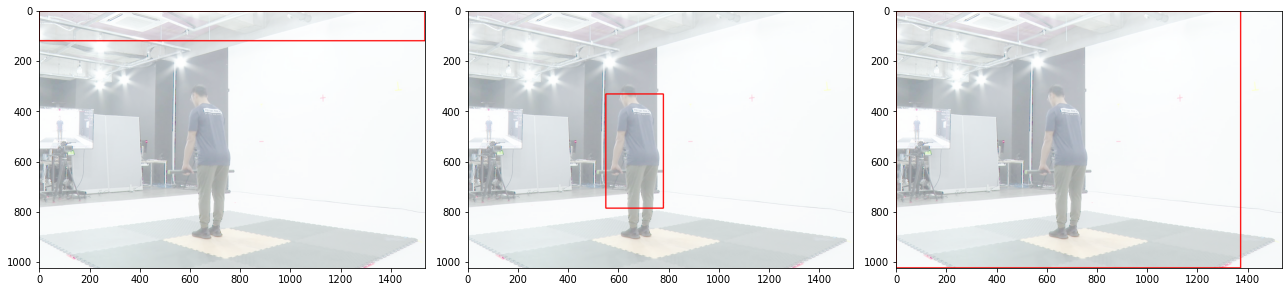

In [19]:
img_ = utils.normalize(utils.denormalize(img) ** 0.2)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy(),
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"]
    ]
)

### Gamma Correction (gamma = 0.1)

In [21]:
img_ = utils.normalize(utils.denormalize(img) ** 0.1)
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

<Figure size 0x288 with 0 Axes>

### Rot90, k=1

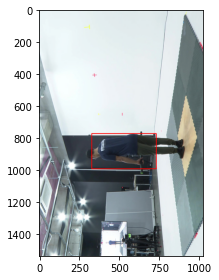

In [23]:
img_ = torch.rot90(img, k=1, dims=(1, 2))
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

### Rot90, k=2

In [24]:
img_ = torch.rot90(img, k=2, dims=(1, 2))
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

<Figure size 0x288 with 0 Axes>

### Rot90, k=3

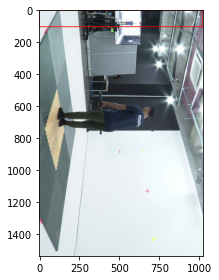

In [25]:
img_ = torch.rot90(img, k=3, dims=(1, 2))
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

### Horizontal Flip

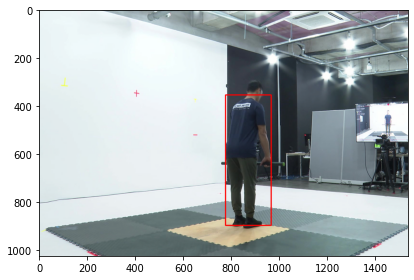

In [29]:
img_ = torch.flip(img, dims=(2,))
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

### Vertical Flip

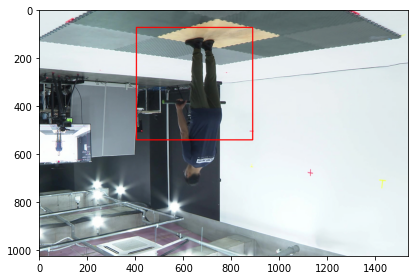

In [31]:
img_ = torch.flip(img, dims=(1,))
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)

### Shrink

In [37]:
img.shape

torch.Size([3, 1024, 1536])

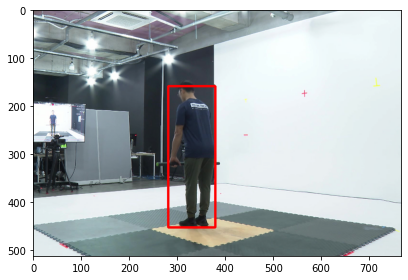

In [35]:
img_ = F.interpolate(img.unsqueeze(0), (512, 768)).squeeze(0)
img_np = utils.denormalize(img_).permute(1, 2, 0).mul(255).type(torch.uint8).numpy()
img_np = np.array(Image.fromarray(img_np))
pannot = model(img_.unsqueeze(0).cuda())[0]
utils.imshows(
    *[
        cv2.rectangle(
            img_np,
            (int(roi[0]), int(roi[1])),
            (int(roi[2]), int(roi[3])),
            (255, 0, 0),
            3,
        )
        for roi in pannot["rois"][:6]
    ]
)